Functions

In [1]:
#Function to test for stationarity
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

In [2]:
#Function to split dataset based on date selected
def train_test_split(df, enddate_train,startdate_test):
    df_train = df[:enddate_train]
    df_test = df[startdate_test:]
    return df_train, df_test

In [3]:
#Function extract X and Y from dataset ADJUST which X variables we want
def X_Y_transform(df):
    X = df[['Corn Price Futures','OIL_PRICE $/bbl','AVG_TAVG']]
    Y = df['price']
    return X, Y

In [5]:
#Function SARIMAX multi step forecast
def sarimax_forecast(history, future, config, step_size):
    order, sorder, trend = config
    # define model
    X_train,Y_train = X_Y_transform(history)
    model = SARIMAX(endog = Y_train, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # multistep forecast
    y_hat = model_fit.predict(len(history), (len(history)+step_size-1))
    return y_hat

In [15]:
#Function Moving window for univariate data
def moving_window(df, step, cfg):
    print("Fitting the combination", cfg)
    predictions = []
    history_size, step_size = step
    history = df[:history_size]
    future = df[history_size:(history_size+step_size)]

    # step over each time-step in the test set
    for i in range(int(math.ceil((len(df)-history_size)/6))):
        # fit model and make forecast for history
        if len(future) < step_size:
            step_size = len(future)

        yhat = sarimax_forecast(history, future, cfg, step_size)
        # store forecast in list of predictions
        if i == 0:
            predictions = yhat
        else:
            predictions = predictions.append(yhat)
        # move the history and forecast window
        history = history.append(future)
        history = history[step_size:]
        future = df[(history_size+(step_size*(i+1))):(history_size+(step_size*(i+2)))]

    # estimate prediction error
    future = df[history_size:]
    X_test,Y_test = X_Y_transform(future)
    score = evaluation_measures(Y_test, predictions)
    #print(predictions)
    print(score)
    return score, predictions

In [7]:
#Function performance measures
def evaluation_measures(actual, predicted):
    mse = np.square(np.subtract(actual, predicted)).mean()
    return mse

In [21]:
#Function to  create a set of sarima configs to try
def sarima_configs(p,q,d,P,D,Q):
    models = list()
    # define config lists
    p_params = list(range(1,p))
    d_params = list(range(0,d))
    q_params = list(range(1,q))
    t_params = ['n']
    P_params = list(range(1,P))
    D_params = list(range(0,D))
    Q_params = list(range(1,Q))
    m_params = [3,5,7]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                     for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [9]:
#Function run grid search configs
def grid_search(df, cfg_list, step):
    scores = list()
    filterwarnings("ignore")
    best_score = np.inf
    best_prediction = list()
    best_cfg = list()

    for cfg in cfg_list:
        score, prediction = moving_window(df, step, cfg)
        scores.append(score)

        if score < best_score:
            print("Found an improved score", score,"is better than", best_score )
            best_score = score
            best_cfg = cfg
            best_prediction = prediction

    return best_cfg, best_score, best_prediction

In [10]:
#Function take log of price and standardize test set
def transform_data_test(df,mean_list, sd_list):
    df.price = np.log(df.price)
    col_list = df.columns

    for i in range(len(col_list)):
        col = col_list[i]
        df[col] = (df[col]-mean_list[i])/sd_list[i]

    #print(df.head(5))
    return df

In [11]:
#Function take log of price and standardize train set
def transform_data_train(df):
    df.price = np.log(df.price)
    col_list = df.columns
    mean_list = []
    sd_list = []
    mean = 0
    sd = 0

    for col in col_list:
        mean = st.mean(df[col])
        sd = st.pstdev(df[col])
        df[col] = (df[col]-mean)/sd
        mean_list.append(mean)
        sd_list.append(sd)

    #print(df.price)
    #print(mean_list)
    #print(sd_list)
    return df, mean_list, sd_list

Automatic main code

In [12]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
from warnings import filterwarnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
import statistics as st
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from datetime import datetime

In [22]:
if __name__ == '__main__':
    #Import data of the required product
    df_maize = pd.read_excel('MAIZE_FILTERED_2023-02-25_19-36-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product
    #df_wheat = pd.read_excel('WHEAT_FILTERED_2023-03-03_02-44-24.xlsx', header=[0, 1], index_col=0) #ADJUST to product
    #df_sunflower = pd.read_excel('SUNFLOWER_FILTERED_2023-02-26_22-04-41.xlsx', header=[0, 1], index_col=0) #ADJUST to product

    #Select which country dataset you want to forcast
    product = 'Maize'
    country = 'France'
    df = df_maize.xs(country, axis = 1, level =1 , drop_level=True) #ADJUST to country

    #split the data in test and train
    enddate_train = "2022-04-01"
    startdate_test = "2019-11-01"

    #df_train, df_test = train_test_split(df, enddate_train,startdate_test )
    df_train_unedited, df_test_unedited = train_test_split(df, enddate_train,startdate_test )

    #take log price and standardize the data
    df_train = df_train_unedited.copy()
    df_train, mean_list, sd_list = transform_data_train(df_train)

    # model configs
    cfg_list = sarima_configs(3,2,3,2,2,2) #sarima_configs(p,q,d,P,D,Q)
cfg_list

[[(1, 0, 1), (1, 0, 1, 3), 'n'],
 [(1, 0, 1), (1, 0, 1, 5), 'n'],
 [(1, 0, 1), (1, 0, 1, 7), 'n'],
 [(1, 0, 1), (1, 1, 1, 3), 'n'],
 [(1, 0, 1), (1, 1, 1, 5), 'n'],
 [(1, 0, 1), (1, 1, 1, 7), 'n'],
 [(1, 1, 1), (1, 0, 1, 3), 'n'],
 [(1, 1, 1), (1, 0, 1, 5), 'n'],
 [(1, 1, 1), (1, 0, 1, 7), 'n'],
 [(1, 1, 1), (1, 1, 1, 3), 'n'],
 [(1, 1, 1), (1, 1, 1, 5), 'n'],
 [(1, 1, 1), (1, 1, 1, 7), 'n'],
 [(1, 2, 1), (1, 0, 1, 3), 'n'],
 [(1, 2, 1), (1, 0, 1, 5), 'n'],
 [(1, 2, 1), (1, 0, 1, 7), 'n'],
 [(1, 2, 1), (1, 1, 1, 3), 'n'],
 [(1, 2, 1), (1, 1, 1, 5), 'n'],
 [(1, 2, 1), (1, 1, 1, 7), 'n'],
 [(2, 0, 1), (1, 0, 1, 3), 'n'],
 [(2, 0, 1), (1, 0, 1, 5), 'n'],
 [(2, 0, 1), (1, 0, 1, 7), 'n'],
 [(2, 0, 1), (1, 1, 1, 3), 'n'],
 [(2, 0, 1), (1, 1, 1, 5), 'n'],
 [(2, 0, 1), (1, 1, 1, 7), 'n'],
 [(2, 1, 1), (1, 0, 1, 3), 'n'],
 [(2, 1, 1), (1, 0, 1, 5), 'n'],
 [(2, 1, 1), (1, 0, 1, 7), 'n'],
 [(2, 1, 1), (1, 1, 1, 3), 'n'],
 [(2, 1, 1), (1, 1, 1, 5), 'n'],
 [(2, 1, 1), (1, 1, 1, 7), 'n'],
 [(2, 2, 1

In [23]:
    step = [24,6] #history horizon and multistepforecast

    # grid search on train dataset with minimum MSE
    best_cfg, lowest_score, predictions_train = grid_search(df_train, cfg_list,step)
    print('Gridsearch found with best parameters', best_cfg, "with MSE equal to", lowest_score)


Fitting the combination [(1, 0, 1), (1, 0, 1, 3), 'n']
12.215659634697758
Found an improved score 12.215659634697758 is better than inf
Fitting the combination [(1, 0, 1), (1, 0, 1, 5), 'n']
0.9559559352695038
Found an improved score 0.9559559352695038 is better than 12.215659634697758
Fitting the combination [(1, 0, 1), (1, 0, 1, 7), 'n']
8.69422983936336e+20
Fitting the combination [(1, 0, 1), (1, 1, 1, 3), 'n']
14.620155044474332
Fitting the combination [(1, 0, 1), (1, 1, 1, 5), 'n']
48266112.82391476
Fitting the combination [(1, 0, 1), (1, 1, 1, 7), 'n']
14.686211984122112
Fitting the combination [(1, 1, 1), (1, 0, 1, 3), 'n']
4.004804617004973
Fitting the combination [(1, 1, 1), (1, 0, 1, 5), 'n']
3.2997713012019063
Fitting the combination [(1, 1, 1), (1, 0, 1, 7), 'n']
4080.755116184125
Fitting the combination [(1, 1, 1), (1, 1, 1, 3), 'n']
6.8019429759533745
Fitting the combination [(1, 1, 1), (1, 1, 1, 5), 'n']
8.28025965545979e+22
Fitting the combination [(1, 1, 1), (1, 1, 1, 

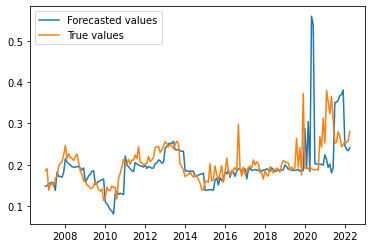

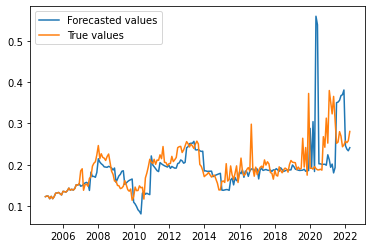

In [24]:
#Visulaize the train results
predictions_train_destandardize = np.exp(predictions_train*sd_list[df.columns.get_loc("price")]+mean_list[df.columns.get_loc("price")])

#plot only forcast horizon
plt.plot(predictions_train_destandardize,label='Forecasted values')
plt.plot(df_train_unedited.price[step[0]:],label='True values')
plt.legend()
plt.show()

#plot on full period
trueprices = df_train_unedited.price
forecasted_prices = trueprices[:len(trueprices)-len(predictions_train_destandardize)]
forecasted_prices = forecasted_prices.append(predictions_train_destandardize)


plt.plot(forecasted_prices,label='Forecasted values')
plt.plot(trueprices,label='True values')
plt.legend()
plt.show()

Fitting the combination [(1, 0, 1), (1, 0, 1, 5), 'n']
1.728317349296071
For France with orders [(1, 0, 1), (1, 0, 1, 5), 'n'] we find MSE: 1.728317349296071 MAE: 0.9753845859949367 MAPE: 0.4395317920827025


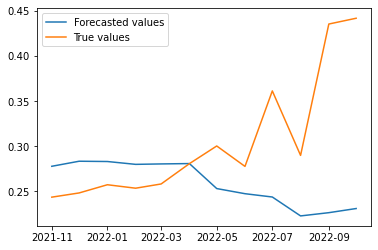

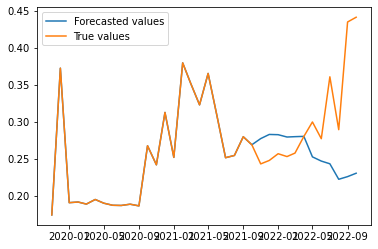

In [25]:
#Run test set
df_test = df_test_unedited.copy()
df_test = transform_data_test(df_test, mean_list,sd_list)

score_test, predictions_test = moving_window(df_test, step, best_cfg)

predictions_test_destandardize = np.exp(predictions_test*sd_list[df.columns.get_loc("price")]+mean_list[df.columns.get_loc("price")])

#measures MSE, MAE,MAPE
#MSE = mean_squared_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)
#MAE = mean_absolute_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)
#MAPE = mean_absolute_percentage_error(df_test_unedited.price[step[0]:], predictions_test_destandardize)

MSE = mean_squared_error(df_test.price[step[0]:], predictions_test)
MAE = mean_absolute_error(df_test.price[step[0]:], predictions_test)
MAPE = mean_absolute_percentage_error(df_test.price[step[0]:], predictions_test)

print("For",country,"with orders",best_cfg,"we find MSE:", MSE,"MAE:",MAE,"MAPE:",MAPE)
#Visulaize the test results

#plot only forcast horizon
plt.plot(predictions_test_destandardize,label='Forecasted values')
plt.plot(df_test_unedited.price[step[0]:],label='True values')
plt.legend()
plt.show()

#plot on full period
trueprices_t = df_test_unedited.price
forecasted_pricest = trueprices_t[:len(trueprices_t)-len(predictions_test_destandardize)]
forecasted_pricest = forecasted_pricest.append(predictions_test_destandardize)


plt.plot(forecasted_pricest,label='Forecasted values')
plt.plot(trueprices_t,label='True values')
plt.legend()
plt.show()

In [26]:
#Export Forecasts
destand_pred = pd.DataFrame(predictions_test_destandardize)
destand_pred.rename(columns={'predicted_mean': 'Predictions',}, inplace=True)

stand_pred = pd.DataFrame(predictions_test)
stand_pred.rename(columns={'predicted_mean': 'Standerdized Predictions',}, inplace=True)

export = pd.concat([stand_pred,destand_pred], axis = 1)
export = pd.concat([export,df_test_unedited.price[step[0]:]], axis = 1)

# get the current date and time
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# save the DataFrame to an Excel file with the current timestamp in the file name
filename = f'SARIMA_{product}_{country}_{now}_{best_cfg}.xlsx'
export.to_excel(filename, index=True)